<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap12/Trial6(use_content_folder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"!

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5ue0dr80
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-9mq23_6f
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!!


In [0]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap12/'
os.chdir(folder)
print(os.getcwd()) 
for items in os.listdir(folder):
   print(items)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap12
template
Trial1.ipynb
Trial2.ipynb
tiny-imagenet-200
annotations
Trial5.ipynb
newtinymodel.pt
Experiment.ipynb


In [0]:
import torch
import torchvision
from template import TinyImageNet
from template import DatasetFromSubset
from template import download_extract
from template import Albumentationtransform
from template import chap12ResNet

In [0]:
cd /content

/content


In [0]:
!ls

gdrive	sample_data


In [0]:
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
fileName = "tiny-imagenet-200.zip"
download_extract.download_images(IMAGES_URL)

In [0]:
ls /content/tiny-imagenet-200

test/  train/  val/  wnids.txt  words.txt


In [0]:
def get_classes(download_folder):
    classes = []
    wnids = open(os.path.join(download_folder,"wnids.txt"), "r")
    for line in wnids:
        classes.append(line.strip())
    return classes

download_folder = '/content/tiny-imagenet-200/'
print(download_folder)
if (os.path.isdir(download_folder)==False):
    print(download_folder," does not exist")
else :    
    classes = get_classes(download_folder)
    print(classes)

/content/tiny-imagenet-200/
['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n0266972

In [0]:
import albumentations as A
import cv2
train_transform = Albumentationtransform.AlbumentationTransforms([                              
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.Rotate(limit=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = Albumentationtransform.AlbumentationTransforms([A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [0]:
from torch.utils.data import Dataset, random_split
import numpy as np

train_split = 70
dataset = TinyImageNet.TinyImageNet(classes,download_folder)
train_len = len(dataset)*train_split//100
test_len = len(dataset) - train_len 
train_set, val_set = random_split(dataset, [train_len, test_len])
print(len(train_set))
print(len(val_set))
train_dataset = DatasetFromSubset.DatasetFromSubset(train_set, transform=train_transform)
test_dataset = DatasetFromSubset.DatasetFromSubset(val_set, transform=test_transform)


77000
33000


In [0]:
batch_size=256
num_workers=4
pin_memory=True
SEED = 1
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if cuda:
			torch.cuda.manual_seed(SEED)
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

trainloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
testloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [0]:
!pip install torchsummary
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = chap12ResNet.ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.2, total_steps=None, epochs=30, steps_per_epoch=1, pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

In [0]:
from template import train_test
train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,7,scheduler,batch_scheduler=False,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap12/newtinymodel.pt")

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.02


Loss=4.125701427459717 Batch_id=300 Accuracy=6.34: 100%|██████████| 301/301 [05:19<00:00,  1.06s/it]



Test set: Average loss: 0.0167, Accuracy: 3330/33000 (10.09%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.04


Loss=3.8904869556427 Batch_id=300 Accuracy=13.45: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]



Test set: Average loss: 0.0146, Accuracy: 5825/33000 (17.65%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.06


Loss=3.2620391845703125 Batch_id=300 Accuracy=19.38: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]



Test set: Average loss: 0.0148, Accuracy: 6238/33000 (18.90%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.08


Loss=3.2728590965270996 Batch_id=300 Accuracy=23.72: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]



Test set: Average loss: 0.0128, Accuracy: 8171/33000 (24.76%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.1


Loss=3.1207125186920166 Batch_id=300 Accuracy=28.12: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]



Test set: Average loss: 0.0121, Accuracy: 9572/33000 (29.01%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.12000000000000002


Loss=2.9077959060668945 Batch_id=300 Accuracy=31.19: 100%|██████████| 301/301 [05:29<00:00,  1.10s/it]



Test set: Average loss: 0.0118, Accuracy: 10348/33000 (31.36%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.14


Loss=2.715780735015869 Batch_id=300 Accuracy=34.27: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]



Test set: Average loss: 0.0120, Accuracy: 10301/33000 (31.22%)



In [0]:
from template import train_test
train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,8,scheduler,batch_scheduler=False,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap12/newtinymodel.pt")

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.16


Loss=2.658712148666382 Batch_id=300 Accuracy=36.92: 100%|██████████| 301/301 [05:29<00:00,  1.10s/it]



Test set: Average loss: 0.0120, Accuracy: 10095/33000 (30.59%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.18


Loss=2.467191696166992 Batch_id=300 Accuracy=39.28: 100%|██████████| 301/301 [05:28<00:00,  1.09s/it]



Test set: Average loss: 0.0100, Accuracy: 12959/33000 (39.27%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.2


Loss=2.5155975818634033 Batch_id=300 Accuracy=41.56: 100%|██████████| 301/301 [05:28<00:00,  1.09s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 12938/33000 (39.21%)

EPOCH: 4 LR: 0.19010000000000002


Loss=2.3146770000457764 Batch_id=300 Accuracy=43.70: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 12514/33000 (37.92%)

EPOCH: 5 LR: 0.1802


Loss=1.9792704582214355 Batch_id=300 Accuracy=45.90: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]



Test set: Average loss: 0.0095, Accuracy: 14181/33000 (42.97%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.1703


Loss=2.3333823680877686 Batch_id=300 Accuracy=47.73: 100%|██████████| 301/301 [05:28<00:00,  1.09s/it]



Test set: Average loss: 0.0092, Accuracy: 14690/33000 (44.52%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.16040000000000001


Loss=2.034482479095459 Batch_id=300 Accuracy=49.40: 100%|██████████| 301/301 [05:28<00:00,  1.09s/it]



Test set: Average loss: 0.0089, Accuracy: 14902/33000 (45.16%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.15050000000000002


Loss=2.1464998722076416 Batch_id=300 Accuracy=50.76: 100%|██████████| 301/301 [05:28<00:00,  1.09s/it]



Test set: Average loss: 0.0100, Accuracy: 13679/33000 (41.45%)



In [0]:
from template import evaluate
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 41 %


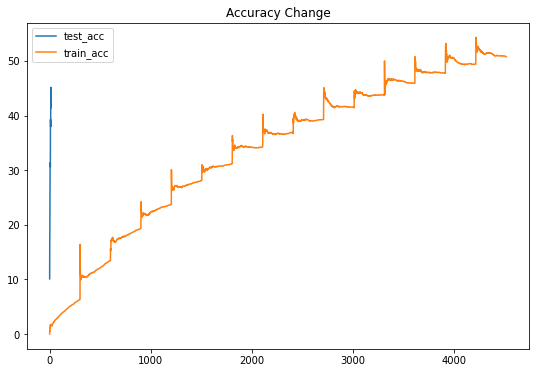

In [0]:
import matplotlib.pyplot as plt
def plot_curve(curves,title,Figsize = (7,7)):
    fig = plt.figure(figsize=Figsize)
    ax = plt.subplot()
    for curve in curves:
        ax.plot(curve[0], label=curve[1])
        plt.title(title)
    ax.legend()
    plt.show()
curves = [(train_test.test_acc,"test_acc"),(train_test.train_acc,"train_acc")]
plot_curve(curves,"Accuracy Change",Figsize = (9,6))